In [2]:
# 0. Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

<Figure size 640x480 with 0 Axes>

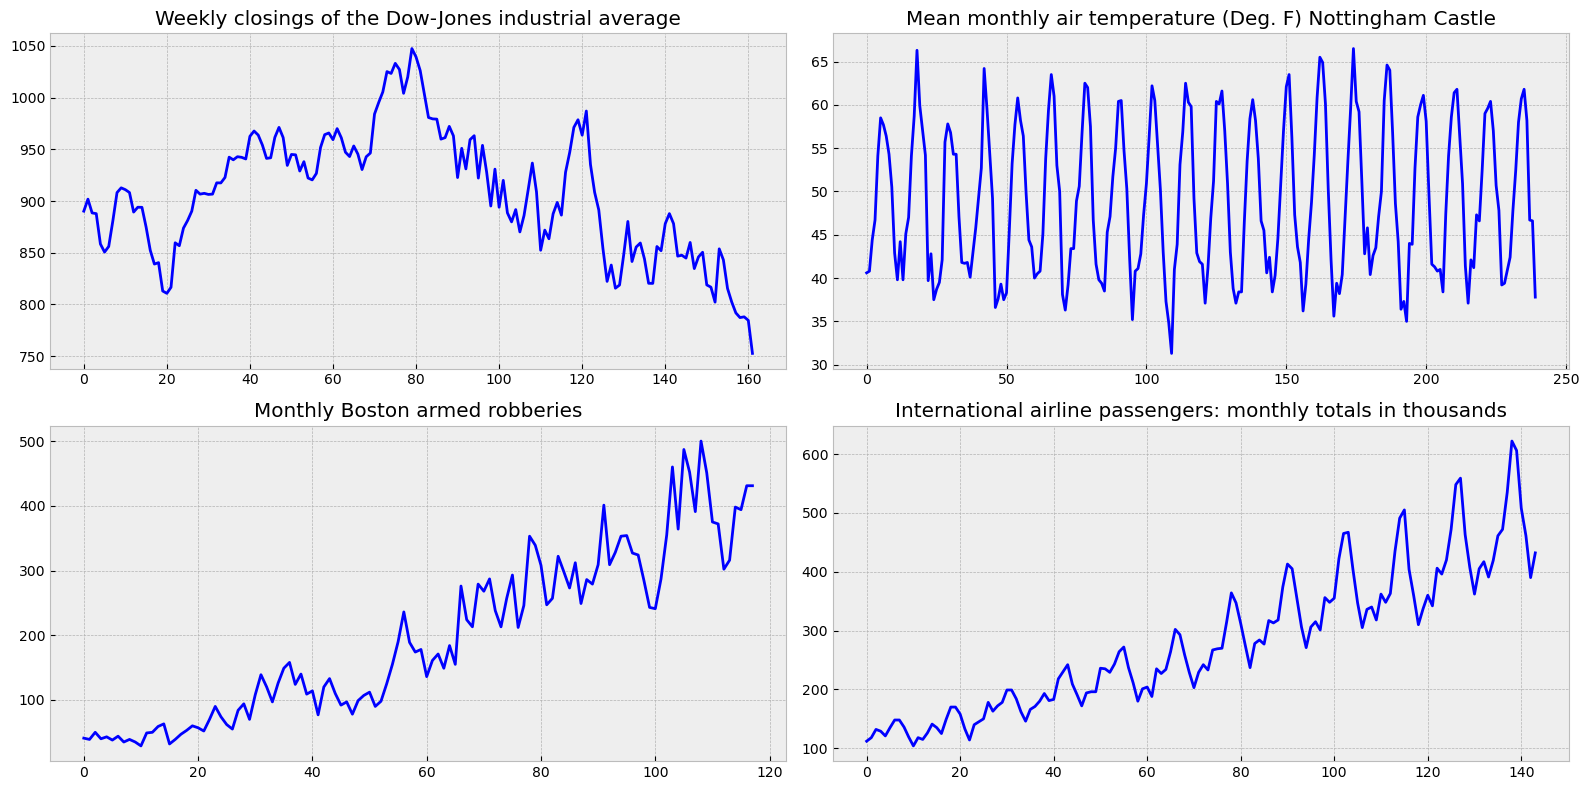

In [3]:
# 1. Init data
dowjones_closing = pd.read_csv("Datasets/weekly-closings-of-the-dowjones-.csv")
mean_monthly_temp = pd.read_csv("Datasets/mean-monthly-air-temperature-deg.csv")
robberies_in_boston = pd.read_csv("Datasets/monthly-boston-armed-robberies-j.csv")
airlines_passengers  = pd.read_csv("Datasets/international-airline-passengers.csv")

all_series = {
    "Weekly closings of the Dow-Jones industrial average": dowjones_closing["Close"],
    "Mean monthly air temperature (Deg. F) Nottingham Castle": mean_monthly_temp["Deg"],
    "Monthly Boston armed robberies": robberies_in_boston["Count"],
    "International airline passengers: monthly totals in thousands": airlines_passengers["Count"]
}

with plt.style.context('bmh'):
    plt.clf()
    plt.figure(figsize=(16, 8))
    layout = (2, 2)
    for i, key in enumerate(all_series.keys()):
        x = i % 2
        y = int((i - x) / 2)
        
        ts_ax = plt.subplot2grid(layout, (y, x))
        all_series[key].plot(ax=ts_ax, color='blue')
        ts_ax.set_title(key)
        
    plt.tight_layout()
    plt.show()

### 2.1. Weekly closings of the Dow-Jones industrial average

In [172]:
series = all_series['Weekly closings of the Dow-Jones industrial average']

<Figure size 640x480 with 0 Axes>

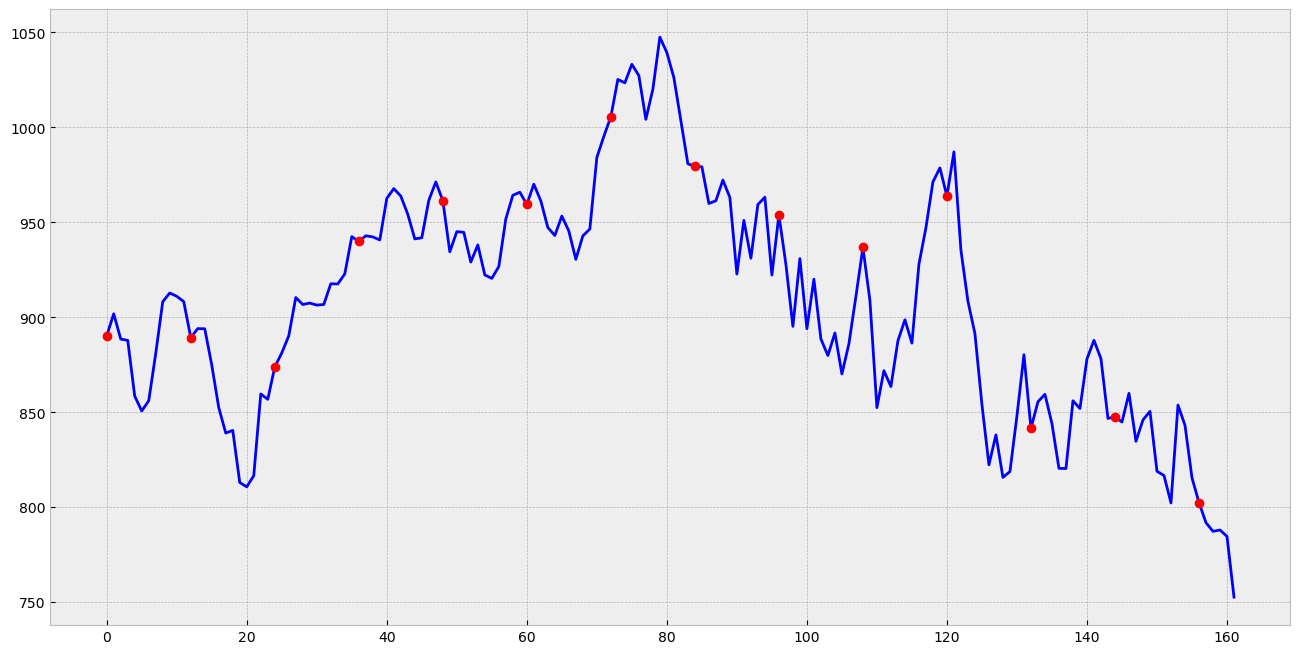

In [173]:
def plot_ts_and_points(ts, start_point, step):
    new_series = [None for i in range(len(ts))]
    for i in range(len(ts)):
        pos = start_point + step * i
        if pos >= len(ts):
            break
        new_series[pos] = ts[pos]
    new_series = pd.Series(new_series)
    
    with plt.style.context('bmh'):
        plt.clf()
        plt.figure(figsize=(16, 8))
        ts_ax = plt.axes()
        ts.plot(ax=ts_ax, color='blue')
        new_series.plot(ax=ts_ax, style='ro')
        plt.show()


plot_ts_and_points(series, 0, 12)

<b>Because there isn't the obvious seasonality, there the double exponential moving average would be a good choice for getting a smoothing graph. But let's start with just EMA

<Figure size 640x480 with 0 Axes>

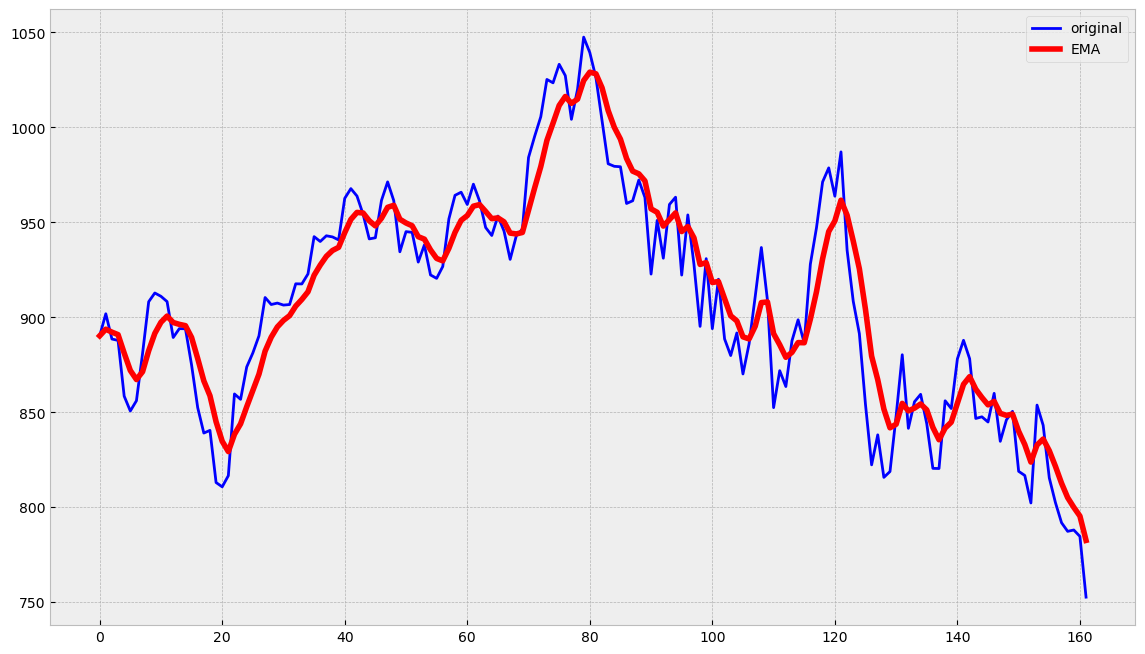

In [174]:
# plot the exponential moving average

# method for calc the exponential moving average
def exponential_moving_average(ser, alpha):
    result = [ser[0]]
    for n in range(1, len(ser)):
        result.append(alpha * ser[n] + (1 - alpha) * result[n-1])
    return pd.Series(result)

# call exponential_moving_average with the alpha equals 0.3
ema = exponential_moving_average(series, 0.3)

with plt.style.context('bmh'):
    plt.clf()
    plt.figure(figsize=(14, 8))
    plt.plot(series, color='blue',label='original')
    plt.plot(ema, color='red', linewidth='4', label='EMA')
    plt.legend()
    plt.show()

<b> Got not bad smoothed plot. Let's also added the double EMA with cross-validation, the looking for the best alpha and beta and getting some predictions

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 305.4357102507921
        x: [ 9.000e-01  2.642e-01]
      nit: 6
      jac: [-8.341e+01 -1.364e-03]
     nfev: 36
     njev: 12
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>


<Figure size 640x480 with 0 Axes>

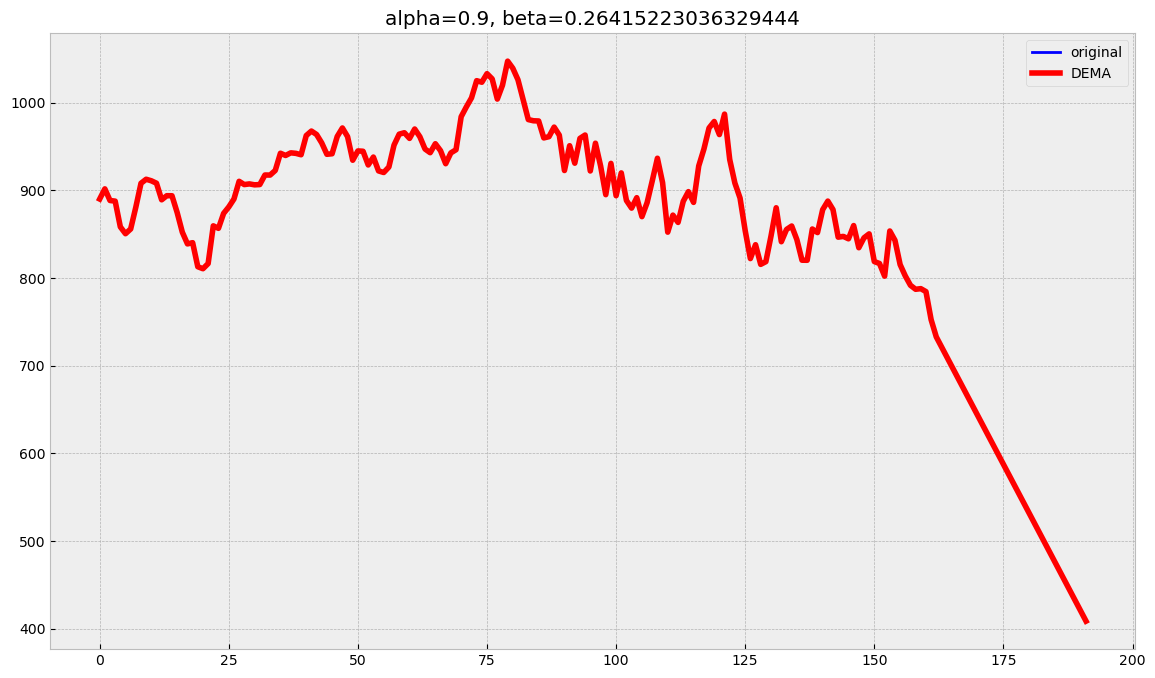

In [124]:
from sklearn.model_selection import TimeSeriesSplit
from scipy.optimize import minimize 
from sklearn.metrics import mean_squared_error

def double_ema_with_preds(ser, alpha, beta, n_preds):
    result = [ser[0]]
    level, trend = ser[0], ser[1] - ser[0]
    for n in range(1, len(ser)):
        value = ser[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)

    len_series = len(ser)
    preds = []
    ser_res = ser.copy()
    for n in range(n_preds):
        value = result[-1]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
        preds.append(level+trend)
        ser_res[len_series+n] = level+trend

    return ser_res, pd.Series(result)

# for plot graph 
def plot_dema(alpha, beta, ser, n_preds):
    dema, _ =  double_ema_with_preds(ser, alpha, beta, n_preds)
    with plt.style.context('bmh'):
        plt.clf()
        plt.figure(figsize=(14, 8))
        plt.plot(ser, color='blue',label='original')
        plt.plot(dema, color='red', linewidth='4', label='DEMA')
        plt.title("alpha={}, beta={}".format(alpha, beta))
        plt.legend()
        plt.show()


# Init data
train, val = series[:65], series[65:]

# Create scoring method with cross-validation
def mse_cross_val(X):
    alpha, beta = X
    split = TimeSeriesSplit(n_splits=2) 
    errors = []
    
    for train_split, test_split in split.split(train):
        train_split_ts = train.iloc[train_split]
        test_split_ts = train.iloc[test_split]
        result, _ = double_ema_with_preds(train_split_ts, alpha, beta, len(test_split)) 
        predictions = result[-len(test_split_ts):]
        error = mean_squared_error(predictions, test_split_ts)
        errors.append(error)
    return np.mean(np.array(errors))


# Call the minimize from scipy for looking for optimize alpha, beta
opt = minimize(mse_cross_val, x0=[0,0], method="L-BFGS-B", bounds = ((0, 0.9), (0, 0.9)))

# Get opt perams 
alpha_opt, beta_opt = opt.x
print(opt)

# Use gotten params in plot_tema (see case 4.5.)
plot_dema(alpha_opt, beta_opt, ser=series, n_preds=30)


<b> got the almost identical graph, but the prediction is just a decreasing trend

### 2.2. Mean monthly air temperature (Deg. F) Nottingham Castle

<b> let's apply here a Moving Average and Exponential MA

In [128]:
series = all_series['Mean monthly air temperature (Deg. F) Nottingham Castle']

<Figure size 640x480 with 0 Axes>

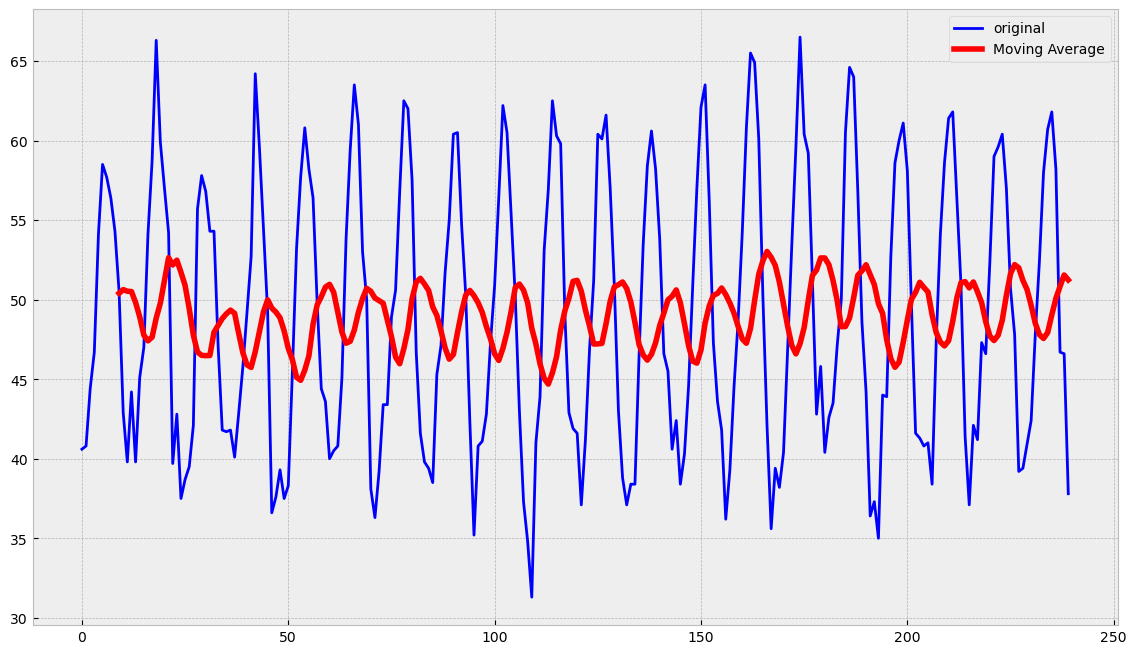

In [132]:
def moving_average(ser, n):
    if not isinstance(ser, pd.Series):
        ser = pd.Series(ser)
    return ser.rolling(n).mean()

# call moving_average with the window equals 7
mov_av = moving_average(series, 10)


with plt.style.context('bmh'):
    plt.clf()
    plt.figure(figsize=(14, 8))
    plt.plot(series, color='blue',label='original')
    plt.plot(mov_av, color='red', linewidth='4', label='Moving Average')
    plt.legend()
    plt.show()

<b> MA has a high delay

<Figure size 640x480 with 0 Axes>

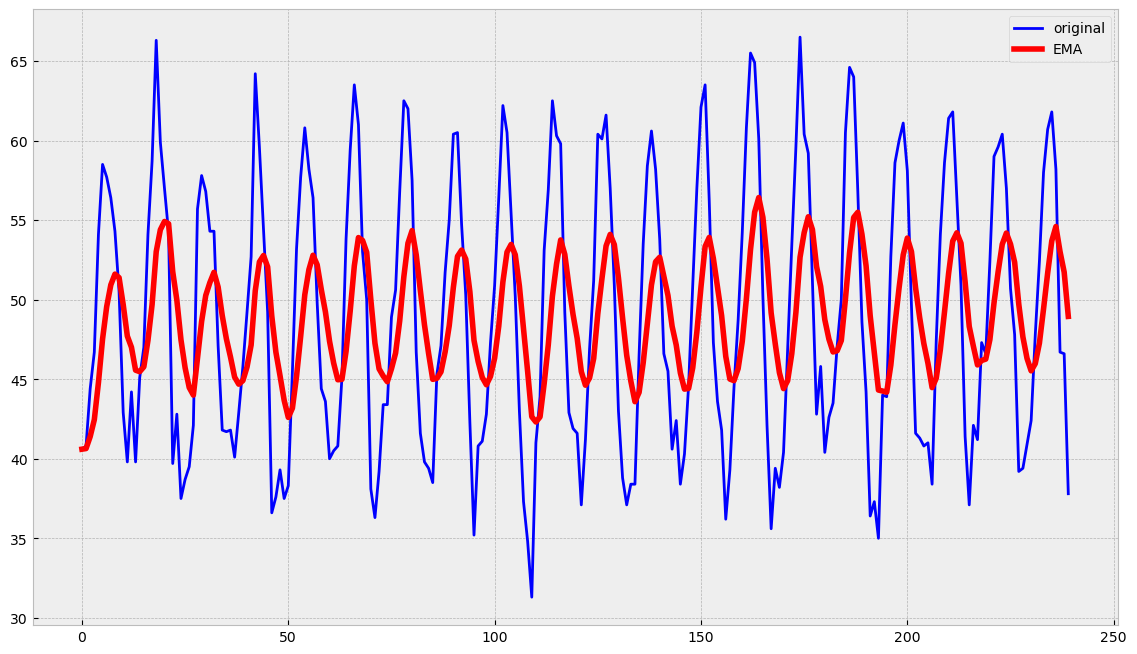

In [134]:
# call exponential_moving_average with the alpha equals 0.2
ema = exponential_moving_average(series, 0.2)

with plt.style.context('bmh'):
    plt.clf()
    plt.figure(figsize=(14, 8))
    plt.plot(series, color='blue',label='original')
    plt.plot(ema, color='red', linewidth='4', label='EMA')
    plt.legend()
    plt.show()

<b> EMA looks a bit better

### 2.3. Monthly Boston armed robberies

In [135]:
series = all_series['Monthly Boston armed robberies']

<Figure size 640x480 with 0 Axes>

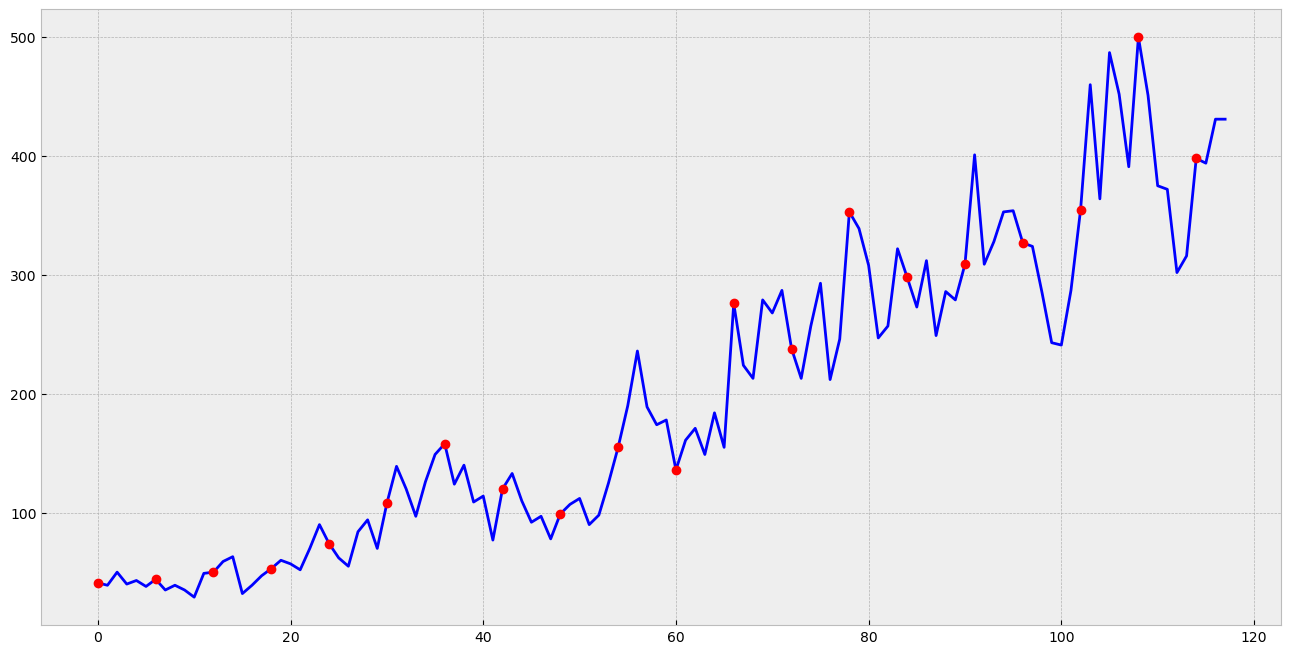

In [160]:
plot_ts_and_points(series, 0, 6)

<b> there also aren't some clear seasonality, but it contains a clear trend. I think the best choice would be a Double EMA.

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 853.1882427740779
        x: [ 5.157e-01  4.052e-01]
      nit: 20
      jac: [ 2.296e-03  1.501e-03]
     nfev: 66
     njev: 22
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>


<Figure size 640x480 with 0 Axes>

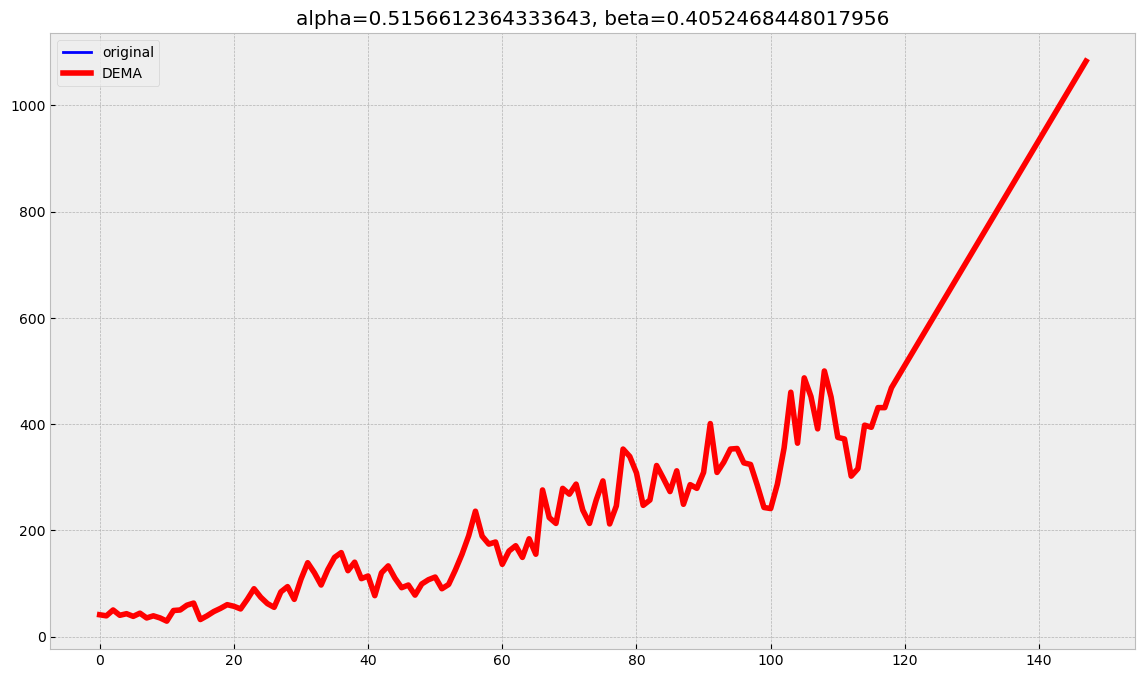

In [161]:
# Init data
train, val = series[:65], series[65:]

# Call the minimize from scipy for looking for optimize alpha, beta
opt = minimize(mse_cross_val, x0=[0,0], method="L-BFGS-B", bounds = ((0, 0.9), (0, 0.9)))

# Get opt perams 
alpha_opt, beta_opt = opt.x
print(opt)

# Use gotten params in plot_tema (see case 4.5.)
plot_dema(alpha_opt, beta_opt, ser=series, n_preds=30)

<Figure size 640x480 with 0 Axes>

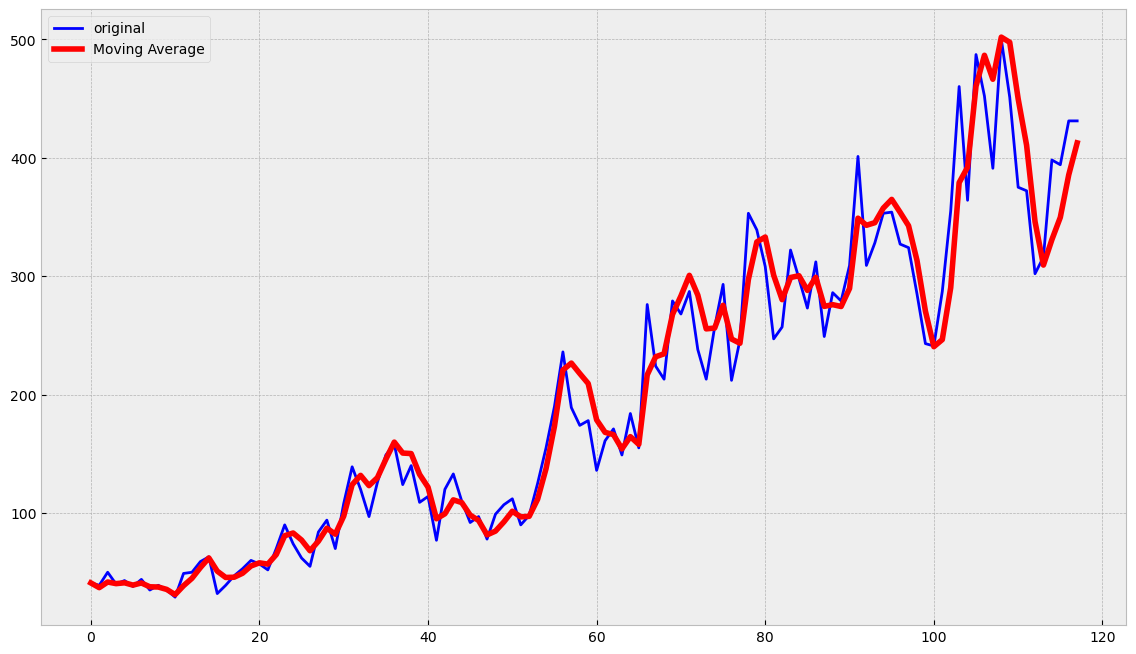

In [169]:
def double_ema(ser, alpha, beta):
    result = [ser[0]]
    level, trend = ser[0], ser[1] - ser[0]
    for n in range(1, len(series)):
        value = ser[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return pd.Series(result)

dema = double_ema(series, 0.4, 0.3)

with plt.style.context('bmh'):
    plt.clf()
    plt.figure(figsize=(14, 8))
    plt.plot(series, color='blue',label='original')
    plt.plot(dema, color='red', linewidth='4', label='Moving Average')
    plt.legend()
    plt.show()

<b> got two graphs:
 - using cross-validation and DEMA, after that we got the similar plot and prediction for trend
 - with manual params alpha and beta, after that we got a just smoothed plot

### 2.4. International airline passengers: monthly totals in thousands

In [176]:
series = all_series['International airline passengers: monthly totals in thousands']

<Figure size 640x480 with 0 Axes>

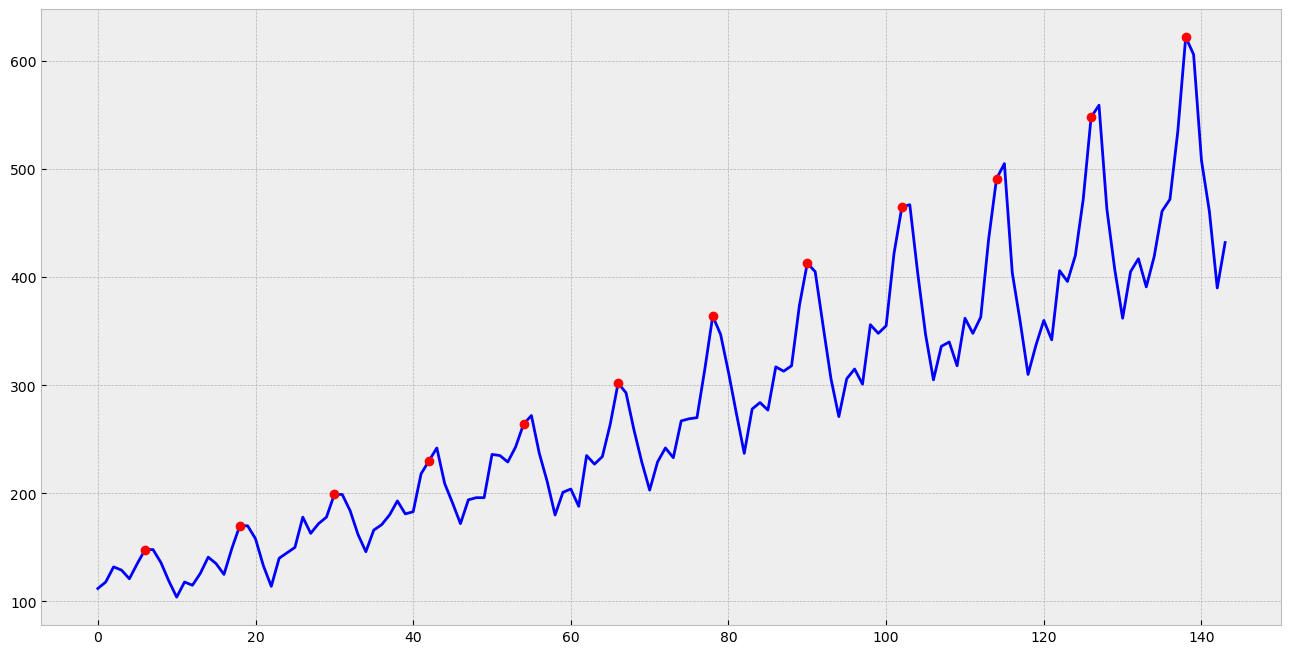

In [186]:
plot_ts_and_points(series, 6, 12)

<b> There is a clear trend and seasonality. Let's construct a Triple Exponental Moving Exponential

<Figure size 640x480 with 0 Axes>

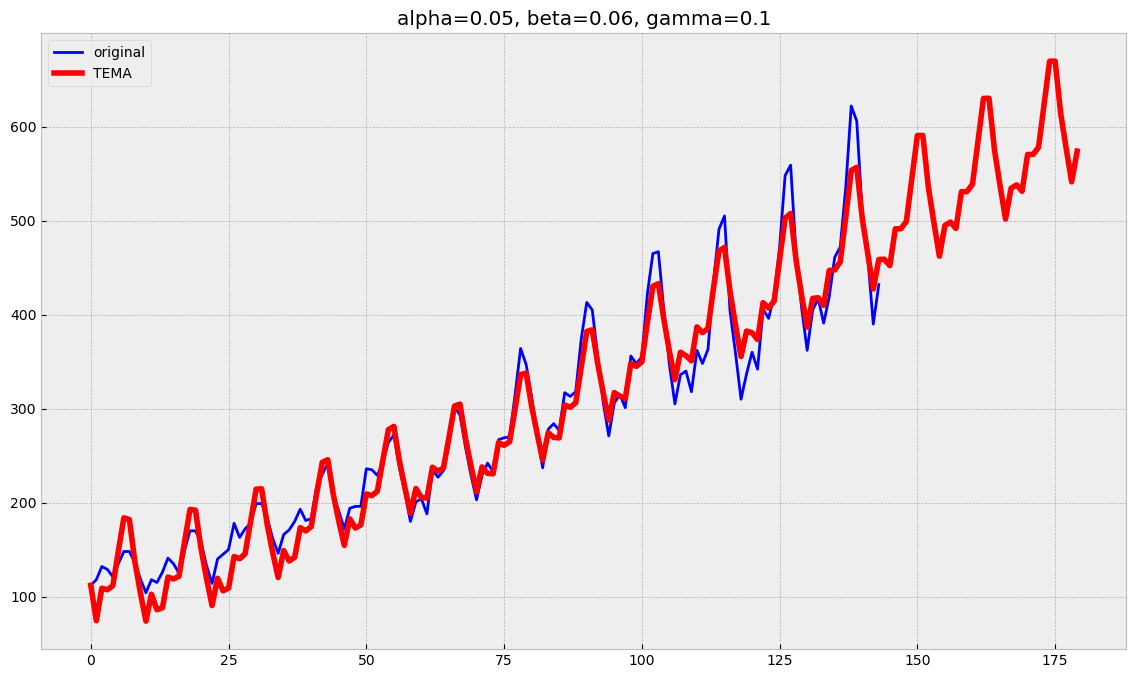

In [179]:
def initial_trend(ser, season_len):
    """
    This function calculates the initial trend of the time series. 
    The trend is the average of the differences between each value and the value season_len steps before it, normalized by season_len.
    """
    return sum([float(ser[i + season_len] - ser[i]) / season_len]) / season_len


def initial_seasonal_components(ser, slen):
    """
    It iterates over each season, calculates the average, and then determines how much each point deviates from these averages.
    
    inputs:
        seasonals stores the seasonal components.
        season_averages stores the average of each season.
    """
    seasonals = {}
    season_averages = []
    n_seasons = int(len(ser)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(ser[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += ser[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals


def triple_exponential_smoothing(ser, slen, alpha, beta, gamma, n_preds):
    """
    The function initializes the smoothed value, trend, and seasonal components, 
    then iterates over the time series to update these values using the smoothing equations. 
    It forecasts future values by extending the series and applying the trend and seasonal components.

    inputs:
        ser is the time series data.
        slen is the length of a season (e.g., 12 for monthly data with yearly seasonality).
        alpha, beta, and gamma are the smoothing parameters.
        n_preds is the number of future points to predict.
    """
    result = []
    seasonals = initial_seasonal_components(ser, slen)
    for i in range(len(ser)+n_preds):
        if i == 0: # initial values
            smooth = ser[0]
            trend = initial_trend(ser, slen)
            result.append(ser[0])
            continue
        if i >= len(ser): # we are forecasting
            m = i - len(ser) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = ser[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result


def plot_tema(alpha, beta, gamma, ser=series, ser_to_plot=series, n_preds=36):
    tema = triple_exponential_smoothing(ser, 12, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.clf()
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue',label='original')
        plt.plot(tema, color='red', linewidth='4', label='TEMA')
        plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.legend()
        plt.show()


plot_tema(0.05, 0.06, 0.1)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 177.42069833342185
        x: [ 9.997e-01  4.530e-02  9.999e-01]
      nit: 14
      jac: [ 4.889e-04 -6.179e-03  1.842e-03]
     nfev: 68
     njev: 17
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>


<Figure size 640x480 with 0 Axes>

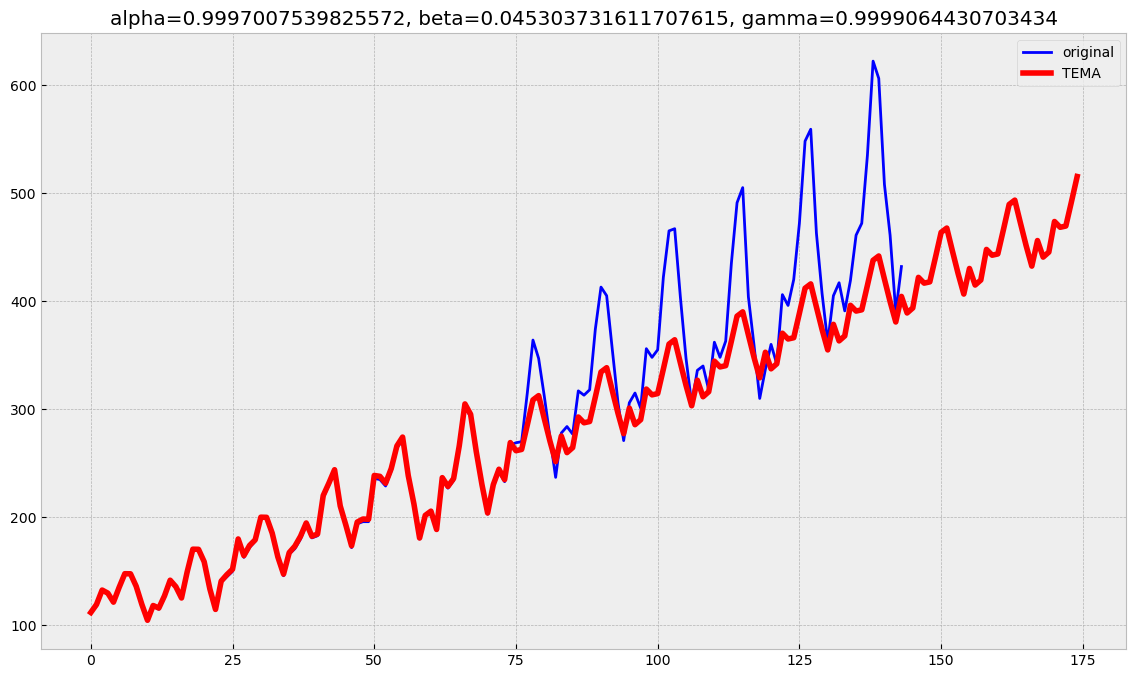

In [201]:
# Init data
train, val = series[:75], series[75:]

# Create scoring method with cross-validation
def mse_cross_val(X):
    alpha, beta, gamma = X
    split = TimeSeriesSplit(n_splits=2) 
    errors = []
    
    for train_split, test_split in split.split(train):
        train_split_ts = train.iloc[train_split]
        test_split_ts = train.iloc[test_split]
        result = triple_exponential_smoothing(train_split_ts, 12, alpha, beta, gamma, len(test_split)) 
        predictions = result[-len(test_split_ts):]
        error = mean_squared_error(predictions, test_split_ts)
        errors.append(error)
    return np.mean(np.array(errors))


# Call the minimize from scipy for looking for optimize alpha, beta and gamma
opt = minimize(mse_cross_val, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

# Get opt perams 
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

# Use gotten params in plot_tema (see case 4.5.)
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=train, ser_to_plot=series, n_preds=100)

<b> got two graphs:
- using cross-validation and TEMA, after that we got the similar plot and prediction for trend and seasonality
- with manual params alpha, beta and gamma, after that we got a just smoothed plot